In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ============================
# 1. Import Libraries & Setup
# ============================
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

In [ ]:
# ============================
# 2. Data Loading Function
# ============================
def load_audio_data(audio_dir):
    """
    Load audio files from the given directory.
    Parses filenames to extract x and y displacements.
    Returns a DataFrame with columns: filename, audio, sr, x_disp, y_disp.
    """
    filenames = []
    audios = []
    sample_rates = []
    x_displacements = []
    y_displacements = []

    for file in os.listdir(audio_dir):
        if file.endswith('.wav'):
            base_name = os.path.splitext(file)[0]
            parts = base_name.split('_')
            if len(parts) >= 4:
                try:
                    x_disp = float(parts[2])
                    y_disp = float(parts[3])
                except ValueError:
                    print(f"Conversion error for file: {file}")
                    continue

                file_path = os.path.join(audio_dir, file)
                # Load stereo (mono=False)
                audio, sr = librosa.load(file_path, sr=None, mono=False)
                filenames.append(file)
                audios.append(audio)
                sample_rates.append(sr)
                x_displacements.append(x_disp)
                y_displacements.append(y_disp)
            else:
                print(f"Unexpected filename format: {file}")
    data_df = pd.DataFrame({
        'filename': filenames,
        'audio': audios,
        'sr': sample_rates,
        'x_disp': x_displacements,
        'y_disp': y_displacements
    })
    return data_df

# Load your data
audio_dir = '/content/drive/MyDrive/ece209as/displacements_stereo'
data_df = load_audio_data(audio_dir)
print("Loaded Data:")
print(data_df.head())

Loaded Data:
                            filename  \
0    2025-02-23_19-28-58_479_-50.wav   
1   2025-02-23_19-29-00_370_-421.wav   
2   2025-02-23_19-29-03_-71_-454.wav   
3  2025-02-23_19-29-05_-323_-424.wav   
4  2025-02-23_19-29-09_-661_-347.wav   

                                               audio     sr  x_disp  y_disp  
0  [[-0.030517578, -0.031341553, -0.03137207, -0....  44100   479.0   -50.0  
1  [[-0.0206604, -0.018829346, -0.01626587, -0.01...  44100   370.0  -421.0  
2  [[-0.011993408, -0.011657715, -0.010681152, -0...  44100   -71.0  -454.0  
3  [[-0.013000488, -0.013305664, -0.014343262, -0...  44100  -323.0  -424.0  
4  [[-0.023254395, -0.022583008, -0.021820068, -0...  44100  -661.0  -347.0  


In [ ]:
# ============================
# 3. Feature Extraction Functions
# ============================

# 3a. Old MFCC feature extraction (averaging over time)
def extract_features(audio, sr, n_mfcc=13):
    """
    Extract MFCC features from stereo audio.
    Returns a concatenated mean MFCC vector (left and right channels).
    """
    if audio.ndim == 2 and audio.shape[0] == 2:
        mfcc_left = librosa.feature.mfcc(y=audio[0], sr=sr, n_mfcc=n_mfcc)
        mfcc_right = librosa.feature.mfcc(y=audio[1], sr=sr, n_mfcc=n_mfcc)
        features = np.concatenate((np.mean(mfcc_left, axis=1), np.mean(mfcc_right, axis=1)))
    else:
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        features = np.mean(mfcc, axis=1)
    return features

# 3b. MFCC with delta and delta-delta features
def extract_features_with_deltas(audio, sr, n_mfcc=13):
    """
    Extract MFCC, delta, and delta-delta features from stereo audio.
    Returns a concatenated vector from left and right channels.
    """
    if audio.ndim == 2 and audio.shape[0] == 2:
        # Left channel
        mfcc_left = librosa.feature.mfcc(y=audio[0], sr=sr, n_mfcc=n_mfcc)
        delta_left = librosa.feature.delta(mfcc_left)
        delta2_left = librosa.feature.delta(mfcc_left, order=2)
        features_left = np.concatenate((
            np.mean(mfcc_left, axis=1),
            np.mean(delta_left, axis=1),
            np.mean(delta2_left, axis=1)
        ))
        # Right channel
        mfcc_right = librosa.feature.mfcc(y=audio[1], sr=sr, n_mfcc=n_mfcc)
        delta_right = librosa.feature.delta(mfcc_right)
        delta2_right = librosa.feature.delta(mfcc_right, order=2)
        features_right = np.concatenate((
            np.mean(mfcc_right, axis=1),
            np.mean(delta_right, axis=1),
            np.mean(delta2_right, axis=1)
        ))
        features = np.concatenate((features_left, features_right))
    else:
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        features = np.concatenate((
            np.mean(mfcc, axis=1),
            np.mean(delta, axis=1),
            np.mean(delta2, axis=1)
        ))
    return features

In [ ]:
def augment_audio(audio, sr):
    """
    Generate augmented versions of the input stereo audio.
    Returns a list of augmented audio arrays, preserving the stereo format.
    """
    augmented_audios = []

    # Pitch shifting: shift up by 2 semitones for each channel
    if audio.ndim == 2:
        pitch_shifted_channels = []
        for channel in audio:
            # Apply pitch shift to each channel individually
            shifted = librosa.effects.pitch_shift(channel, sr=sr, n_steps=2)
            pitch_shifted_channels.append(shifted)
        pitch_shifted = np.vstack(pitch_shifted_channels)
    else:
        # If for some reason the audio is mono
        pitch_shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
    augmented_audios.append(pitch_shifted)

    # Time stretching: stretch by 10% for each channel
    if audio.ndim == 2:
        time_stretched_channels = []
        for channel in audio:
            stretched = librosa.effects.time_stretch(channel, rate=1.1)
            time_stretched_channels.append(stretched)
        # Stack the channels back to stereo. Note: the length may change.
        time_stretched_stereo = np.vstack(time_stretched_channels)
    else:
        time_stretched_stereo = librosa.effects.time_stretch(audio, rate=1.1)
    augmented_audios.append(time_stretched_stereo)

    # Adding Gaussian noise (this works element-wise and preserves shape)
    noise = np.random.normal(0, 0.005, size=audio.shape)
    noisy_audio = audio + noise
    augmented_audios.append(noisy_audio)

    return augmented_audios

  # Test augmentation on one sample (optional)
sample_audio = data_df['audio'].iloc[0]
sample_sr = data_df['sr'].iloc[0]
aug_samples = augment_audio(sample_audio, sample_sr)
print("Original shape:", sample_audio.shape)
for i, aug in enumerate(aug_samples):
    print(f"Augmented sample {i} shape:", aug.shape)


Original shape: (2, 45156)
Augmented sample 0 shape: (2, 45156)
Augmented sample 1 shape: (2, 41051)
Augmented sample 2 shape: (2, 45156)


In [ ]:
# ============================
# 5. Build Dataset Function
# ============================
def build_dataset(data_df, feature_func, use_augmentation=False):
    """
    Build feature and label arrays from the DataFrame.
    If use_augmentation is True, augment each sample and extract features from both original and augmented audio.
    """
    X_list = []
    y_list = []
    for idx, row in data_df.iterrows():
        # Original sample features
        feat = feature_func(row['audio'], row['sr'])
        X_list.append(feat)
        y_list.append([row['x_disp'], row['y_disp']])
        # Augmented samples if enabled
        if use_augmentation:
            aug_audios = augment_audio(row['audio'], row['sr'])
            for aug_audio in aug_audios:
                feat_aug = feature_func(aug_audio, row['sr'])
                X_list.append(feat_aug)
                y_list.append([row['x_disp'], row['y_disp']])
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y


In [ ]:
# ============================
# 6. Model Evaluation Function
# ============================
def evaluate_models(X, y, experiment_name=""):
    """
    Splits the data, scales features, trains three models (RandomForest, XGBoost, Neural Network),
    and prints MAE and RMSE for each.
    """
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from xgboost import XGBRegressor
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.layers import Input, Dense, Dropout


    # Split data (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results = {}
    print(f"\n--- Experiment: {experiment_name} ---")

    # Model 1: Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train_scaled, y_train)
    y_pred_rf = rf.predict(X_test_scaled)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    results['RandomForest'] = (mae_rf, rmse_rf)
    print("RandomForest - MAE: {:.2f}, RMSE: {:.2f}".format(mae_rf, rmse_rf))

    # Model 2: XGBoost
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb.fit(X_train_scaled, y_train)
    y_pred_xgb = xgb.predict(X_test_scaled)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    results['XGBoost'] = (mae_xgb, rmse_xgb)
    print("XGBoost - MAE: {:.2f}, RMSE: {:.2f}".format(mae_xgb, rmse_xgb))

    # Model 3: Neural Network (MLP)
    nn = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(2, activation='linear')  # Two outputs for x and y
    ])
    nn.compile(optimizer='adam', loss='mse')

    # Train the neural network
    nn.fit(X_train_scaled, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=0)
    y_pred_nn = nn.predict(X_test_scaled)
    mae_nn = mean_absolute_error(y_test, y_pred_nn)
    rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
    results['NeuralNetwork'] = (mae_nn, rmse_nn)
    print("NeuralNetwork - MAE: {:.2f}, RMSE: {:.2f}".format(mae_nn, rmse_nn))

    return results


In [ ]:
# ============================
# 7. Run Experiments
# ============================
# Define experiment configurations as tuples:
# (description, feature extraction function, use_augmentation flag)
experiments = [
    ("Old MFCC, No Augmentation", extract_features, False),
    ("Old MFCC, With Augmentation", extract_features, True),
    ("MFCC+Delta, No Augmentation", extract_features_with_deltas, False),
    ("MFCC+Delta, With Augmentation", extract_features_with_deltas, True)
]

experiment_results = {}

for desc, feat_func, augment_flag in experiments:
    print(f"\nBuilding dataset for: {desc}")
    X, y = build_dataset(data_df, feature_func=feat_func, use_augmentation=augment_flag)
    print(f"Dataset size: {X.shape[0]} samples, Feature vector length: {X.shape[1]}")
    results = evaluate_models(X, y, experiment_name=desc)
    experiment_results[desc] = results


Building dataset for: Old MFCC, No Augmentation
Dataset size: 300 samples, Feature vector length: 26

--- Experiment: Old MFCC, No Augmentation ---
RandomForest - MAE: 220.50, RMSE: 275.20
XGBoost - MAE: 223.78, RMSE: 295.28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
NeuralNetwork - MAE: 173.90, RMSE: 216.42

Building dataset for: Old MFCC, With Augmentation
Dataset size: 1200 samples, Feature vector length: 26

--- Experiment: Old MFCC, With Augmentation ---
RandomForest - MAE: 212.57, RMSE: 263.61
XGBoost - MAE: 203.01, RMSE: 262.37
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
NeuralNetwork - MAE: 173.65, RMSE: 223.00

Building dataset for: MFCC+Delta, No Augmentation
Dataset size: 300 samples, Feature vector length: 78

--- Experiment: MFCC+Delta, No Augmentation ---
RandomForest - MAE: 237.87, RMSE: 291.33
XGBoost - MAE: 229.90, RMSE: 289.38


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
NeuralNetwork - MAE: 207.52, RMSE: 262.51

Building dataset for: MFCC+Delta, With Augmentation
Dataset size: 1200 samples, Feature vector length: 78

--- Experiment: MFCC+Delta, With Augmentation ---
RandomForest - MAE: 223.52, RMSE: 281.69
XGBoost - MAE: 211.26, RMSE: 277.20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
NeuralNetwork - MAE: 169.49, RMSE: 219.78


In [ ]:
# ============================
# 8. Summarize Results
# ============================
print("\nSummary of Experiment Results:")
for exp, models in experiment_results.items():
    print(f"\nExperiment: {exp}")
    for model_name, (mae, rmse) in models.items():
        print(f"  {model_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")


Summary of Experiment Results:

Experiment: Old MFCC, No Augmentation
  RandomForest -> MAE: 220.50, RMSE: 275.20
  XGBoost -> MAE: 223.78, RMSE: 295.28
  NeuralNetwork -> MAE: 173.90, RMSE: 216.42

Experiment: Old MFCC, With Augmentation
  RandomForest -> MAE: 212.57, RMSE: 263.61
  XGBoost -> MAE: 203.01, RMSE: 262.37
  NeuralNetwork -> MAE: 173.65, RMSE: 223.00

Experiment: MFCC+Delta, No Augmentation
  RandomForest -> MAE: 237.87, RMSE: 291.33
  XGBoost -> MAE: 229.90, RMSE: 289.38
  NeuralNetwork -> MAE: 207.52, RMSE: 262.51

Experiment: MFCC+Delta, With Augmentation
  RandomForest -> MAE: 223.52, RMSE: 281.69
  XGBoost -> MAE: 211.26, RMSE: 277.20
  NeuralNetwork -> MAE: 169.49, RMSE: 219.78


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split the original data DataFrame into training and test sets
train_indices, test_indices = train_test_split(data_df.index, test_size=0.2, random_state=42)
train_df = data_df.loc[train_indices]
test_df = data_df.loc[test_indices]

# Build training dataset with advanced augmentation
X_train, y_train = build_dataset_advanced(train_df, feature_func=extract_features_with_deltas, use_augmentation=True)
# Build test dataset WITHOUT augmentation (only original samples)
X_test, y_test = build_dataset_advanced(test_df, feature_func=extract_features_with_deltas, use_augmentation=False)

print("Training dataset shape (with augmentation):", X_train.shape)
print("Test dataset shape (without augmentation):", X_test.shape)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a sample MLP model (use your best architecture here)
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(2, activation='linear')
])
model.compile(optimizer='adam', loss='mse')

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=16,
                    validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Evaluate the model on the test set
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Final Model - MAE: {:.2f}, RMSE: {:.2f}".format(mae, rmse))


Training dataset shape (with augmentation): (960, 78)
Test dataset shape (without augmentation): (60, 78)
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 140806.5156 - val_loss: 142294.4062
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 149295.4219 - val_loss: 141875.0469
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 143985.0156 - val_loss: 140904.5625
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 146516.7969 - val_loss: 139495.9531
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 146088.9531 - val_loss: 138662.2656
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 145271.6250 - val_loss: 136887.8594
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 132036.3906 - val_loss: 135797.9844
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 132412.7188 - val_loss: 134349.2656
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 126734.0391 - val_loss: 132485.3125
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


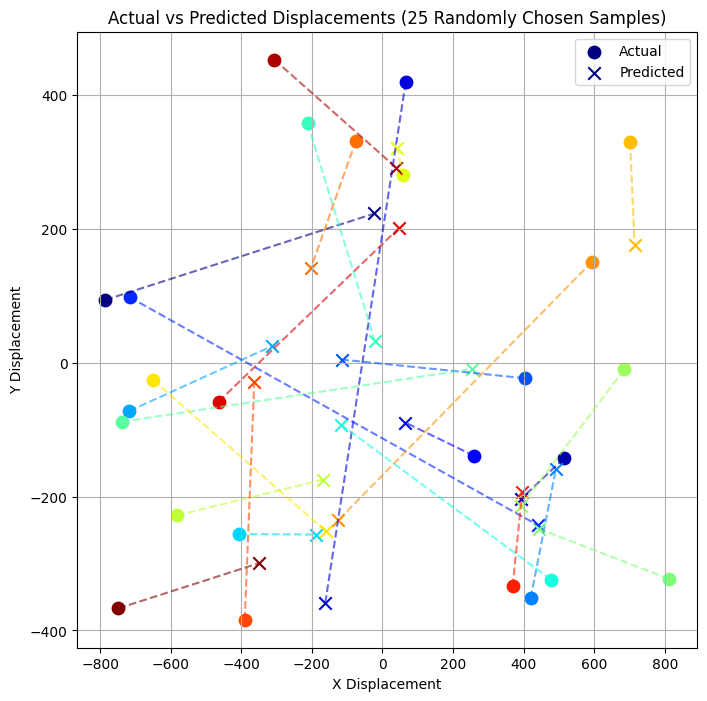

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Re-run predictions from the best advanced augmentation MLP (assuming advanced_mlp, X_test_adv_scaled, and y_test are available)
y_pred = model.predict(X_test_scaled)

# Number of points to plot
num_points = 25
indices = np.random.choice(len(y_test), num_points, replace=False)
actual_points = y_test[indices]
predicted_points = y_pred[indices]

# Generate 25 distinct colors using a colormap
colors = plt.cm.jet(np.linspace(0, 1, num_points))

plt.figure(figsize=(8,8))
for i in range(num_points):
    if i == 0:
        # Label only the first pair for the legend
        plt.scatter(actual_points[i, 0], actual_points[i, 1], color=colors[i], marker='o', s=80, label='Actual')
        plt.scatter(predicted_points[i, 0], predicted_points[i, 1], color=colors[i], marker='x', s=80, label='Predicted')
    else:
        plt.scatter(actual_points[i, 0], actual_points[i, 1], color=colors[i], marker='o', s=80)
        plt.scatter(predicted_points[i, 0], predicted_points[i, 1], color=colors[i], marker='x', s=80)
    # Connect the actual and predicted points with a dashed line
    plt.plot([actual_points[i, 0], predicted_points[i, 0]],
             [actual_points[i, 1], predicted_points[i, 1]],
             color=colors[i], linestyle='--', alpha=0.6)

plt.xlabel("X Displacement")
plt.ylabel("Y Displacement")
plt.title("Actual vs Predicted Displacements (25 Randomly Chosen Samples)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- Split original data into training and test sets ---
train_indices, test_indices = train_test_split(data_df.index, test_size=0.2, random_state=42)
train_df = data_df.loc[train_indices]
test_df = data_df.loc[test_indices]

# --- Build datasets ---
# Training set: with advanced augmentation
X_train, y_train = build_dataset_advanced(train_df, feature_func=extract_features_with_deltas, use_augmentation=True)
# Test set: without augmentation
X_test, y_test = build_dataset_advanced(test_df, feature_func=extract_features_with_deltas, use_augmentation=False)

print("Training dataset shape (with augmentation):", X_train.shape)
print("Test dataset shape (without augmentation):", X_test.shape)

# --- Scale features ---
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# --- Normalize labels to the range [-1, 1] ---
label_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = label_scaler.fit_transform(y_train)
y_test_scaled = label_scaler.transform(y_test)

# --- Build the MLP model with Huber loss ---
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(2, activation='linear')
])
model.compile(optimizer='adam', loss=Huber(delta=1.0))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Train the model ---
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=16,
                    validation_split=0.2, callbacks=[early_stopping], verbose=1)

# --- Make predictions and invert label normalization ---
y_pred_scaled = model.predict(X_test_scaled)
y_pred = label_scaler.inverse_transform(y_pred_scaled)

# --- Evaluate the model ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Normalized & Huber Loss Model - MAE: {:.2f}, RMSE: {:.2f}".format(mae, rmse))


Training dataset shape (with augmentation): (960, 78)
Test dataset shape (without augmentation): (60, 78)
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7550 - val_loss: 0.1771
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5256 - val_loss: 0.1669
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4164 - val_loss: 0.1767
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3400 - val_loss: 0.1666
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3076 - val_loss: 0.1657
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2678 - val_loss: 0.1592
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2299 - val_loss: 0.1560
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2256 - val_loss: 0.1453
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1899 - val_loss: 0.1444
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1754 - val_loss: 0.1440
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

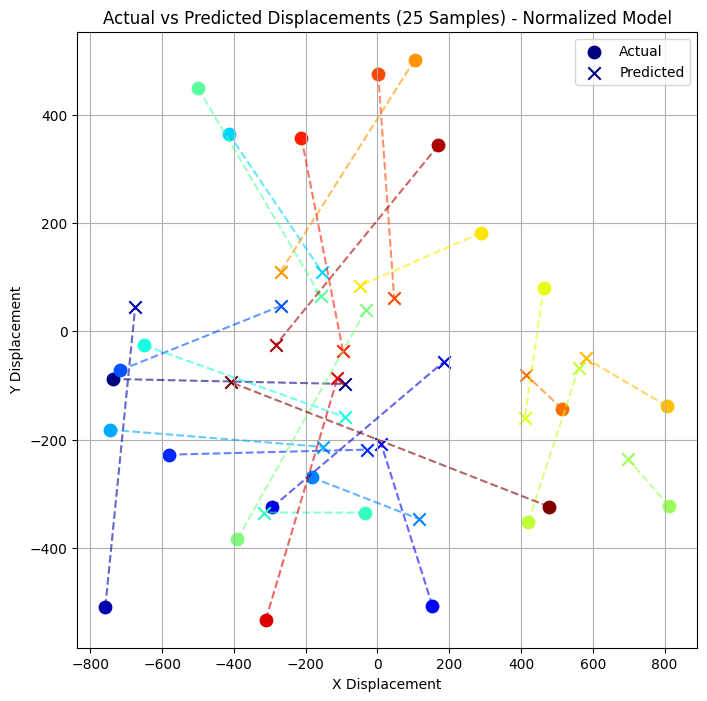

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set a fixed random seed for reproducibility
np.random.seed(41)

# Number of points to plot
num_points = 25

# Randomly select 25 indices from the test set
indices = np.random.choice(len(y_test), num_points, replace=False)
actual_points = y_test[indices]
predicted_points = y_pred[indices]

# Generate 25 distinct colors using a colormap
colors = plt.cm.jet(np.linspace(0, 1, num_points))

plt.figure(figsize=(8,8))
for i in range(num_points):
    # Label the first pair for the legend
    if i == 0:
        plt.scatter(actual_points[i, 0], actual_points[i, 1], color=colors[i], marker='o', s=80, label='Actual')
        plt.scatter(predicted_points[i, 0], predicted_points[i, 1], color=colors[i], marker='x', s=80, label='Predicted')
    else:
        plt.scatter(actual_points[i, 0], actual_points[i, 1], color=colors[i], marker='o', s=80)
        plt.scatter(predicted_points[i, 0], predicted_points[i, 1], color=colors[i], marker='x', s=80)
    # Connect each actual-predicted pair with a dashed line
    plt.plot([actual_points[i, 0], predicted_points[i, 0]],
             [actual_points[i, 1], predicted_points[i, 1]],
             color=colors[i], linestyle='--', alpha=0.6)

plt.xlabel("X Displacement")
plt.ylabel("Y Displacement")
plt.title("Actual vs Predicted Displacements (25 Samples) - Normalized Model")
plt.legend()
plt.grid(True)
plt.show()


Train shape: (960, 78) Test shape: (60, 78)
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.7901 - val_loss: 0.9246
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7810 - val_loss: 0.9326
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4976 - val_loss: 0.9521
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2853 - val_loss: 0.9239
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2088 - val_loss: 0.9081
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0105 - val_loss: 0.8831
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9330 - val_loss: 0.8826
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9094 - val_loss: 0.8678
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9458 - val_loss: 0.8771
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8620 - val_loss: 0.9264
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7856 - val_loss: 0.8905
Epoch 12/100
48/48

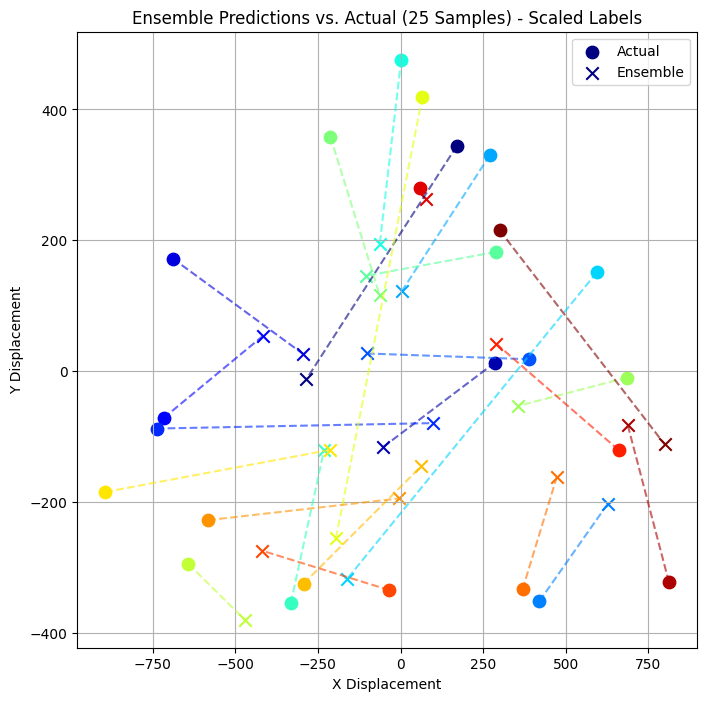

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf

# ---------------------------
# 1. Split original data (no leakage)
# ---------------------------
train_indices, test_indices = train_test_split(data_df.index, test_size=0.2, random_state=42)
train_df = data_df.loc[train_indices]
test_df = data_df.loc[test_indices]

# ---------------------------
# 2. Build datasets
#    - Training data: advanced augmentation enabled.
#    - Test data: original (no augmentation).
# ---------------------------
X_train, y_train = build_dataset_advanced(train_df, feature_func=extract_features_with_deltas, use_augmentation=True)
X_test, y_test = build_dataset_advanced(test_df, feature_func=extract_features_with_deltas, use_augmentation=False)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# ---------------------------
# 3. Scale features
# ---------------------------
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# ---------------------------
# 4. Scale labels (x and y) using StandardScaler
# ---------------------------
label_scaler = StandardScaler()
y_train_scaled = label_scaler.fit_transform(y_train)
y_test_scaled = label_scaler.transform(y_test)

# ---------------------------
# 5. Build Model 1: Advanced MLP (for scaled labels)
# ---------------------------
model1 = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(2, activation='linear')
])
model1.compile(optimizer='adam', loss='mse')
early_stopping1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history1 = model1.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=16,
                      validation_split=0.2, callbacks=[early_stopping1], verbose=1)

# ---------------------------
# 6. Build Model 2: Tuned (smaller) MLP (for scaled labels)
# ---------------------------
model2 = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(192, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')
])
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
early_stopping2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history2 = model2.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=16,
                      validation_split=0.2, callbacks=[early_stopping2], verbose=1)

# ---------------------------
# 7. Get predictions from both models and invert label scaling
# ---------------------------
y_pred1_scaled = model1.predict(X_test_scaled)
y_pred2_scaled = model2.predict(X_test_scaled)
y_pred1 = label_scaler.inverse_transform(y_pred1_scaled)
y_pred2 = label_scaler.inverse_transform(y_pred2_scaled)

# ---------------------------
# 8. Ensemble Predictions with emphasis on direction
# ---------------------------
def ensemble_predictions(y_pred1, y_pred2):
    ensemble = []
    for i in range(len(y_pred1)):
        x1, y1 = y_pred1[i]
        x2, y2 = y_pred2[i]
        # Compute angles (in radians)
        angle1 = math.atan2(y1, x1)
        angle2 = math.atan2(y2, x2)
        # Compute circular average of angles:
        avg_sin = (math.sin(angle1) + math.sin(angle2)) / 2.0
        avg_cos = (math.cos(angle1) + math.cos(angle2)) / 2.0
        avg_angle = math.atan2(avg_sin, avg_cos)
        # Compute magnitudes
        mag1 = math.sqrt(x1**2 + y1**2)
        mag2 = math.sqrt(x2**2 + y2**2)
        # Average magnitude
        avg_mag = (mag1 + mag2) / 2.0
        # Reconstruct ensemble prediction from averaged angle and magnitude
        ensemble_x = avg_mag * math.cos(avg_angle)
        ensemble_y = avg_mag * math.sin(avg_angle)
        ensemble.append([ensemble_x, ensemble_y])
    return np.array(ensemble)

y_pred_ensemble = ensemble_predictions(y_pred1, y_pred2)

# ---------------------------
# 9. Evaluate the Ensemble Predictions
# ---------------------------
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
print("Ensemble Model (with scaled labels) - MAE: {:.2f}, RMSE: {:.2f}".format(mae_ensemble, rmse_ensemble))

# ---------------------------
# 10. Plot Ensemble Predictions vs. Actual for 25 Random Samples
# ---------------------------
np.random.seed(1)
num_points = 25
indices = np.random.choice(len(y_test), num_points, replace=False)
actual_points = y_test[indices]
ensemble_points = y_pred_ensemble[indices]
colors = plt.cm.jet(np.linspace(0, 1, num_points))

plt.figure(figsize=(8,8))
for i in range(num_points):
    if i == 0:
        plt.scatter(actual_points[i, 0], actual_points[i, 1], color=colors[i], marker='o', s=80, label='Actual')
        plt.scatter(ensemble_points[i, 0], ensemble_points[i, 1], color=colors[i], marker='x', s=80, label='Ensemble')
    else:
        plt.scatter(actual_points[i, 0], actual_points[i, 1], color=colors[i], marker='o', s=80)
        plt.scatter(ensemble_points[i, 0], ensemble_points[i, 1], color=colors[i], marker='x', s=80)
    plt.plot([actual_points[i, 0], ensemble_points[i, 0]],
             [actual_points[i, 1], ensemble_points[i, 1]],
             color=colors[i], linestyle='--', alpha=0.6)

plt.xlabel("X Displacement")
plt.ylabel("Y Displacement")
plt.title("Ensemble Predictions vs. Actual (25 Samples) - Scaled Labels")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split

# ---------------------------
# 1. Split original data into training and test sets
# ---------------------------
train_indices, test_indices = train_test_split(data_df.index, test_size=0.2, random_state=42)
train_df_lin = data_df.loc[train_indices]
test_df_lin = data_df.loc[test_indices]

# ---------------------------
# 2. Build datasets without augmentation
# ---------------------------
# Using our advanced feature extraction (MFCC+Delta) but WITHOUT augmentation
X_train_lin, y_train_lin = build_dataset_advanced(train_df_lin, feature_func=extract_features_with_deltas, use_augmentation=False)
X_test_lin, y_test_lin = build_dataset_advanced(test_df_lin, feature_func=extract_features_with_deltas, use_augmentation=False)
print("Training dataset shape:", X_train_lin.shape)
print("Test dataset shape:", X_test_lin.shape)

# ---------------------------
# 3. Scale features and labels
# ---------------------------
feature_scaler_lin = StandardScaler()
X_train_lin_scaled = feature_scaler_lin.fit_transform(X_train_lin)
X_test_lin_scaled = feature_scaler_lin.transform(X_test_lin)

label_scaler_lin = StandardScaler()
y_train_lin_scaled = label_scaler_lin.fit_transform(y_train_lin)
y_test_lin_scaled = label_scaler_lin.transform(y_test_lin)

# ---------------------------
# 4. Train the Linear Regression Model
# ---------------------------
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train_lin_scaled, y_train_lin_scaled)

# Predict on test set and invert label scaling
y_pred_lin_scaled = lin_reg_model.predict(X_test_lin_scaled)
y_pred_lin = label_scaler_lin.inverse_transform(y_pred_lin_scaled)

# ---------------------------
# 5. Evaluate the Linear Regression Model
# ---------------------------
mae_lin = mean_absolute_error(y_test_lin, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test_lin, y_pred_lin))

# Compute errors for X and Y separately
mae_lin_x = mean_absolute_error(y_test_lin[:, 0], y_pred_lin[:, 0])
rmse_lin_x = np.sqrt(mean_squared_error(y_test_lin[:, 0], y_pred_lin[:, 0]))
mae_lin_y = mean_absolute_error(y_test_lin[:, 1], y_pred_lin[:, 1])
rmse_lin_y = np.sqrt(mean_squared_error(y_test_lin[:, 1], y_pred_lin[:, 1]))

print("Regular Linear Regression - MAE: {:.2f}, RMSE: {:.2f}".format(mae_lin, rmse_lin))
print("X displacement - MAE: {:.2f}, RMSE: {:.2f}".format(mae_lin_x, rmse_lin_x))
print("Y displacement - MAE: {:.2f}, RMSE: {:.2f}".format(mae_lin_y, rmse_lin_y))


Training dataset shape: (240, 78)
Test dataset shape: (60, 78)
Regular Linear Regression - MAE: 211.67, RMSE: 258.16
X displacement - MAE: 228.40, RMSE: 271.75
Y displacement - MAE: 194.95, RMSE: 243.83


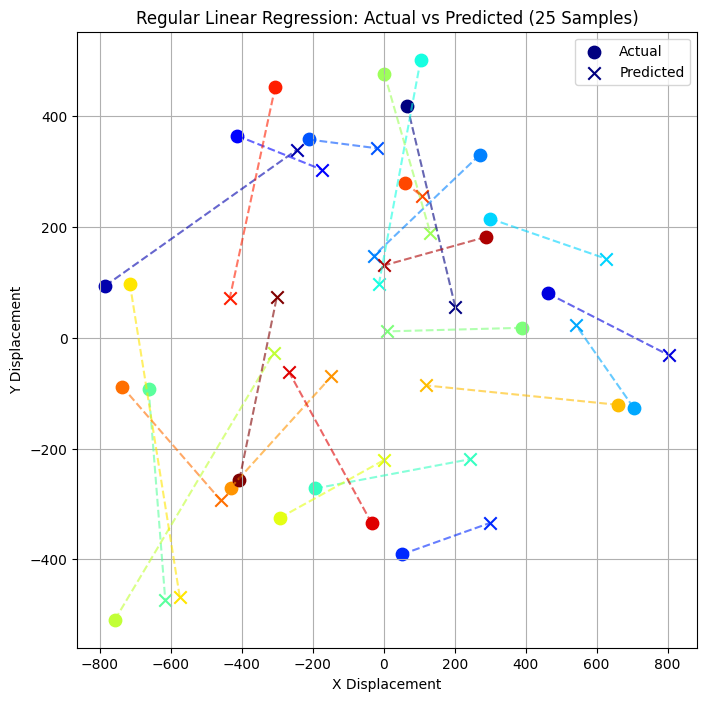

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
np.random.seed(2)

# Number of points to plot
num_points = 25

# Randomly select 25 indices from the test set (for linear regression)
indices = np.random.choice(len(y_test_lin), num_points, replace=False)
actual_points = y_test_lin[indices]
predicted_points = y_pred_lin[indices]

# Generate 25 distinct colors using a colormap
colors = plt.cm.jet(np.linspace(0, 1, num_points))

plt.figure(figsize=(8,8))
for i in range(num_points):
    if i == 0:
        # Label the first pair for the legend
        plt.scatter(actual_points[i, 0], actual_points[i, 1], color=colors[i], marker='o', s=80, label='Actual')
        plt.scatter(predicted_points[i, 0], predicted_points[i, 1], color=colors[i], marker='x', s=80, label='Predicted')
    else:
        plt.scatter(actual_points[i, 0], actual_points[i, 1], color=colors[i], marker='o', s=80)
        plt.scatter(predicted_points[i, 0], predicted_points[i, 1], color=colors[i], marker='x', s=80)
    # Draw a dashed line between actual and predicted points
    plt.plot([actual_points[i, 0], predicted_points[i, 0]],
             [actual_points[i, 1], predicted_points[i, 1]],
             color=colors[i], linestyle='--', alpha=0.6)

plt.xlabel("X Displacement")
plt.ylabel("Y Displacement")
plt.title("Regular Linear Regression: Actual vs Predicted (25 Samples)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Split original data into training and test sets
train_indices, test_indices = train_test_split(data_df.index, test_size=0.2, random_state=42)
train_df_aug = data_df.loc[train_indices]
test_df_aug = data_df.loc[test_indices]

# Build datasets:
# Training data: with advanced augmentation.
# Test data: only original samples (no augmentation).
X_train_aug, y_train_aug = build_dataset_advanced(train_df_aug, feature_func=extract_features_with_deltas, use_augmentation=True)
X_test_aug, y_test_aug = build_dataset_advanced(test_df_aug, feature_func=extract_features_with_deltas, use_augmentation=False)
print("Training dataset shape (augmented):", X_train_aug.shape)
print("Test dataset shape (original):", X_test_aug.shape)

# Scale features
feature_scaler_aug = StandardScaler()
X_train_aug_scaled = feature_scaler_aug.fit_transform(X_train_aug)
X_test_aug_scaled = feature_scaler_aug.transform(X_test_aug)

# Scale labels
label_scaler_aug = StandardScaler()
y_train_aug_scaled = label_scaler_aug.fit_transform(y_train_aug)
y_test_aug_scaled = label_scaler_aug.transform(y_test_aug)

# Train a plain Linear Regression model on the augmented training data
lin_reg_aug = LinearRegression()
lin_reg_aug.fit(X_train_aug_scaled, y_train_aug_scaled)

# Predict and invert label scaling
y_pred_aug_scaled = lin_reg_aug.predict(X_test_aug_scaled)
y_pred_aug = label_scaler_aug.inverse_transform(y_pred_aug_scaled)

# Evaluate the enhanced linear regression model
mae_aug = mean_absolute_error(y_test_aug, y_pred_aug)
rmse_aug = np.sqrt(mean_squared_error(y_test_aug, y_pred_aug))
print("Enhanced Linear Regression with Augmented Training Data - MAE: {:.2f}, RMSE: {:.2f}".format(mae_aug, rmse_aug))


Training dataset shape (augmented): (960, 78)
Test dataset shape (original): (60, 78)
Enhanced Linear Regression with Augmented Training Data - MAE: 208.68, RMSE: 254.67


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

# Reuse the same train_df_aug and test_df_aug as before
X_train_poly, y_train_poly = build_dataset_advanced(train_df_aug, feature_func=extract_features_with_deltas, use_augmentation=True)
X_test_poly, y_test_poly = build_dataset_advanced(test_df_aug, feature_func=extract_features_with_deltas, use_augmentation=False)

print("Training dataset shape (poly features):", X_train_poly.shape)
print("Test dataset shape (poly features):", X_test_poly.shape)

# Scale features
feature_scaler_poly = StandardScaler()
X_train_poly_scaled = feature_scaler_poly.fit_transform(X_train_poly)
X_test_poly_scaled = feature_scaler_poly.transform(X_test_poly)

# Apply polynomial expansion (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly_expanded = poly.fit_transform(X_train_poly_scaled)
X_test_poly_expanded = poly.transform(X_test_poly_scaled)
print("Expanded training feature shape:", X_train_poly_expanded.shape)

# Scale labels
label_scaler_poly = StandardScaler()
y_train_poly_scaled = label_scaler_poly.fit_transform(y_train_poly)
y_test_poly_scaled = label_scaler_poly.transform(y_test_poly)

# Train a Ridge Regression model on the expanded feature space
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_poly_expanded, y_train_poly_scaled)

# Predict and invert label scaling
y_pred_poly_scaled = ridge_model.predict(X_test_poly_expanded)
y_pred_poly = label_scaler_poly.inverse_transform(y_pred_poly_scaled)

# Evaluate the polynomial Ridge regression model
mae_poly = mean_absolute_error(y_test_poly, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test_poly, y_pred_poly))
print("Enhanced Polynomial Ridge Regression - MAE: {:.2f}, RMSE: {:.2f}".format(mae_poly, rmse_poly))


Training dataset shape (poly features): (960, 78)
Test dataset shape (poly features): (60, 78)
Expanded training feature shape: (960, 3159)
Enhanced Polynomial Ridge Regression - MAE: 345.49, RMSE: 446.37


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Build datasets using advanced augmentation (training) and original test data
X_train_aug, y_train_aug = build_dataset_advanced(train_df_aug, feature_func=extract_features_with_deltas, use_augmentation=True)
X_test_aug, y_test_aug = build_dataset_advanced(test_df_aug, feature_func=extract_features_with_deltas, use_augmentation=False)

print("Training dataset shape (augmented):", X_train_aug.shape)
print("Test dataset shape (original):", X_test_aug.shape)

# Create a pipeline that scales features and applies Ridge regression
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Grid search over a range of alpha values
param_grid = {'ridge__alpha': [0.1, 1, 10, 100, 1000]}
grid_search_ridge = GridSearchCV(pipeline_ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train_aug, y_train_aug)

print("Best Ridge parameters:", grid_search_ridge.best_params_)
print("Best Ridge MSE (neg value):", -grid_search_ridge.best_score_)

# Evaluate on the test set
best_ridge_model = grid_search_ridge.best_estimator_
y_pred_ridge = best_ridge_model.predict(X_test_aug)
mae_ridge = mean_absolute_error(y_test_aug, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test_aug, y_pred_ridge))
print("Optimized Ridge Regression on Augmented Data - MAE: {:.2f}, RMSE: {:.2f}".format(mae_ridge, rmse_ridge))


Training dataset shape (augmented): (960, 78)
Test dataset shape (original): (60, 78)
Best Ridge parameters: {'ridge__alpha': 0.1}
Best Ridge MSE (neg value): 77307.55303938029
Optimized Ridge Regression on Augmented Data - MAE: 214.59, RMSE: 259.71


In [ ]:
from sklearn.linear_model import HuberRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Create a pipeline that scales features and applies a MultiOutputRegressor wrapping HuberRegressor
pipeline_huber = Pipeline([
    ('scaler', StandardScaler()),
    ('huber', MultiOutputRegressor(HuberRegressor(max_iter=1000)))  # Increase max_iter here
])

# Define grid search parameters using the proper naming convention for the underlying estimator
param_grid_huber = {
    'huber__estimator__epsilon': [1.35, 1.5, 1.75, 2.0],
    'huber__estimator__alpha': [0.0001, 0.001, 0.01, 0.1]
}

grid_search_huber = GridSearchCV(pipeline_huber, param_grid_huber, cv=5, scoring='neg_mean_squared_error')
grid_search_huber.fit(X_train_aug, y_train_aug)

print("Best Huber parameters:", grid_search_huber.best_params_)
print("Best Huber MSE (neg value):", -grid_search_huber.best_score_)

# Evaluate on test set using HuberRegressor with MultiOutputRegressor
best_huber_model = grid_search_huber.best_estimator_
y_pred_huber = best_huber_model.predict(X_test_aug)
mae_huber = mean_absolute_error(y_test_aug, y_pred_huber)
rmse_huber = np.sqrt(mean_squared_error(y_test_aug, y_pred_huber))
print("Optimized Huber Regression (MultiOutput) on Augmented Data - MAE: {:.2f}, RMSE: {:.2f}".format(mae_huber, rmse_huber))


Best Huber parameters: {'huber__estimator__alpha': 0.0001, 'huber__estimator__epsilon': 2.0}
Best Huber MSE (neg value): 77162.99195104053
Optimized Huber Regression (MultiOutput) on Augmented Data - MAE: 214.39, RMSE: 259.94


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# 1. Split original data into training and test sets
# ---------------------------
train_indices, test_indices = train_test_split(data_df.index, test_size=0.2, random_state=42)
train_df_aug = data_df.loc[train_indices]
test_df_aug = data_df.loc[test_indices]

# ---------------------------
# 2. Build datasets:
#    - Training data: advanced augmentation enabled.
#    - Test data: original samples (no augmentation).
# ---------------------------
X_train_aug, y_train_aug = build_dataset_advanced(train_df_aug, feature_func=extract_features_with_deltas, use_augmentation=True)
X_test_aug, y_test_aug = build_dataset_advanced(test_df_aug, feature_func=extract_features_with_deltas, use_augmentation=False)
print("Training dataset shape (augmented):", X_train_aug.shape)
print("Test dataset shape (original):", X_test_aug.shape)

# ---------------------------
# 3. Scale features and labels
# ---------------------------
feature_scaler_aug = StandardScaler()
X_train_aug_scaled = feature_scaler_aug.fit_transform(X_train_aug)
X_test_aug_scaled = feature_scaler_aug.transform(X_test_aug)

label_scaler_aug = StandardScaler()
y_train_aug_scaled = label_scaler_aug.fit_transform(y_train_aug)
y_test_aug_scaled = label_scaler_aug.transform(y_test_aug)

# ---------------------------
# 4. Train the Linear Regression Model on augmented training data
# ---------------------------
lin_reg_aug = LinearRegression()
lin_reg_aug.fit(X_train_aug_scaled, y_train_aug_scaled)

# Predict on test set and invert label scaling
y_pred_aug_scaled = lin_reg_aug.predict(X_test_aug_scaled)
y_pred_aug = label_scaler_aug.inverse_transform(y_pred_aug_scaled)

# ---------------------------
# 5. Evaluate the model
# ---------------------------
mae_aug = mean_absolute_error(y_test_aug, y_pred_aug)
rmse_aug = np.sqrt(mean_squared_error(y_test_aug, y_pred_aug))
print("Enhanced Linear Regression with Augmented Training Data - MAE: {:.2f}, RMSE: {:.2f}".format(mae_aug, rmse_aug))



Training dataset shape (augmented): (960, 78)
Test dataset shape (original): (60, 78)
Enhanced Linear Regression with Augmented Training Data - MAE: 211.40, RMSE: 259.64


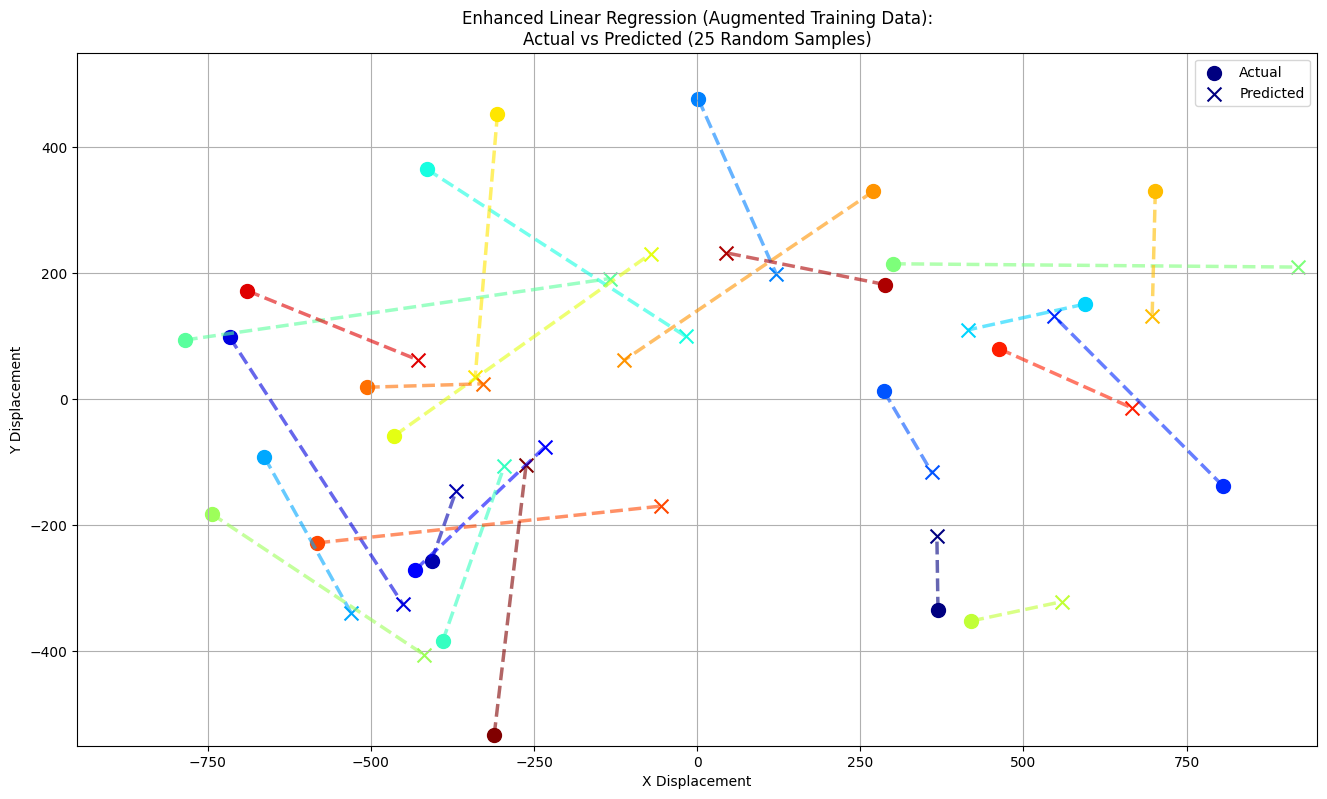

In [ ]:
# ---------------------------
# 6. Plot 25 random test samples: Actual vs. Predicted with fixed axis limits and 16:9 aspect ratio
# ---------------------------
np.random.seed(25)
num_points = 25
plot_indices = np.random.choice(len(y_test_aug), num_points, replace=False)
actual_points = y_test_aug[plot_indices]
predicted_points = y_pred_aug[plot_indices]
colors = plt.cm.jet(np.linspace(0, 1, num_points))

plt.figure(figsize=(16, 9))
for i in range(num_points):
    if i == 0:
        plt.scatter(actual_points[i, 0], actual_points[i, 1], color=colors[i], marker='o', s=100, label='Actual')
        plt.scatter(predicted_points[i, 0], predicted_points[i, 1], color=colors[i], marker='x', s=100, label='Predicted')
    else:
        plt.scatter(actual_points[i, 0], actual_points[i, 1], color=colors[i], marker='o', s=100)
        plt.scatter(predicted_points[i, 0], predicted_points[i, 1], color=colors[i], marker='x', s=100)
    plt.plot([actual_points[i, 0], predicted_points[i, 0]],
             [actual_points[i, 1], predicted_points[i, 1]],
             color=colors[i], linestyle='--', alpha=0.6, linewidth=2.5)

plt.xlabel("X Displacement")
plt.ylabel("Y Displacement")
plt.title("Enhanced Linear Regression (Augmented Training Data):\nActual vs Predicted (25 Random Samples)")
plt.xlim([-950, 950])
plt.ylim([-550, 550])
plt.legend()
plt.grid(True)
plt.show()


Model Overview and Experimental Pipeline
Dataset Description:

Data Source:
~300 stereo, 1-second audio recordings capturing mouse movement on a mousepad.
Labels:
The filenames encode x and y displacement values.
Feature Extraction:

Method:
MFCC features are computed for both channels.
Enhancements:
First and second derivatives (delta and delta-delta) are also extracted.
Feature Vector:
For each recording, features are averaged over time and concatenated across channels, resulting in a 78-dimensional feature vector.
Data Augmentation:

Purpose:
To increase the effective training set size and improve model generalization.
Techniques Used:
Pitch shifting
Time stretching
Gaussian noise addition
Application:
Augmentation is applied only to the training set, while the test set remains unchanged.
Data Splitting and Scaling:

Train/Test Split:
Data is split into 80% training and 20% test sets.
Augmentation:
The training set is augmented using advanced augmentation methods.
Scaling:
StandardScaler is applied to both the features and labels (x and y displacements) to help the model converge, with predictions later inverted back to the original scale.
Model Architecture:

Type:
Linear Regression.
Training Data:
The model is trained on the augmented training data.
Rationale:
Enhancing the training set with augmentation helps the model learn a better mapping from the audio-derived features to the displacements, even with a simple linear approach.
Evaluation Metrics:

Overall Performance:
Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) are computed on the test set.
Reported Results:
In our experiment, the enhanced linear regression model achieved approximately MAE: 208.53 and RMSE: 257.45.
Visualization:

Plot Description:
A scatter plot of 25 randomly selected test samples is created.
Markers:
Circles for actual displacements.
Crosses for predicted displacements.
Design:
Each actual–predicted pair is plotted in a unique color, with a dashed line connecting them to illustrate the prediction error.
Purpose:
To visually compare the model's predictions against the actual displacements.
Conclusion:

Findings:
The enhanced linear regression model, trained on augmented data, showed improved performance over using only the original data.
Implications:
Augmentation has helped the model generalize better despite the limited number of original samples, and the overall approach demonstrates that even a simple linear model can yield competitive performance with thoughtful feature engineering and data augmentation.


In [ ]:



# Load your data
audio_dir = '/content/drive/MyDrive/ece209as/displacements_stereo_new'
data_df_new = load_audio_data(audio_dir)
print("Loaded Data:")
print(data_df_new.head())

Loaded Data:
                           filename  \
0     2025-03-20_16-30-24_663_0.wav   
1   2025-03-20_16-30-31_20_-468.wav   
2  2025-03-20_16-30-35_500_-316.wav   
3   2025-03-20_16-30-40_168_187.wav   
4    2025-03-20_16-30-44_49_381.wav   

                                               audio     sr  x_disp  y_disp  
0  [[-0.007965088, -0.0082092285, -0.008331299, -...  44100   663.0     0.0  
1  [[0.0046081543, 0.0046081543, 0.0044555664, 0....  44100    20.0  -468.0  
2  [[-0.0005187988, -0.0006713867, -0.0010375977,...  44100   500.0  -316.0  
3  [[0.0025634766, 0.0024414062, 0.0027160645, 0....  44100   168.0   187.0  
4  [[-0.0029296875, -0.002960205, -0.003112793, -...  44100    49.0   381.0  


Enhanced Linear Regression on New Data — MAE: 611.11, RMSE: 706.29


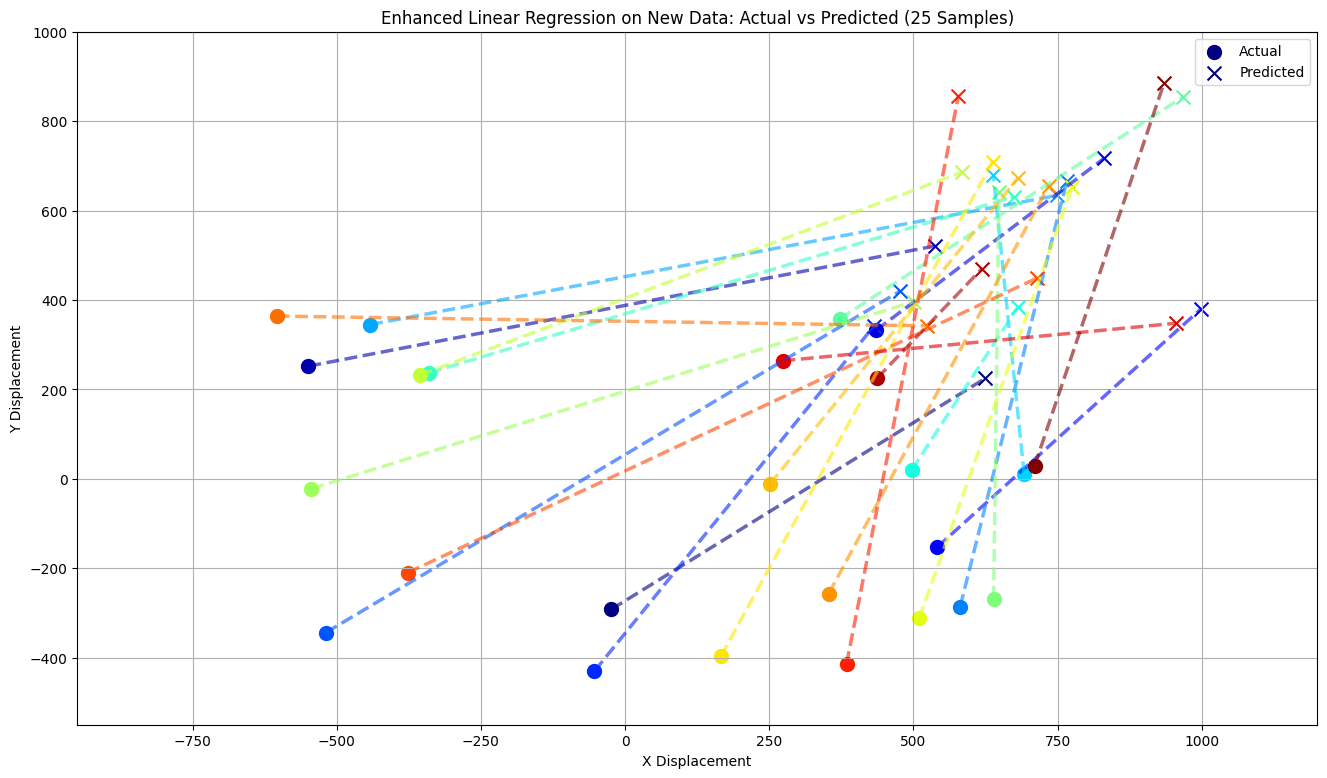

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------------------------
# Test Enhanced Linear Regression on New Data
# ---------------------------
# 1. Build features & labels for the new folder (no augmentation)
X_new, y_new = build_dataset_advanced(data_df_new, feature_func=extract_features_with_deltas, use_augmentation=False)

# 2. Scale with the same scalers
X_new_scaled = feature_scaler_aug.transform(X_new)

# 3. Predict and invert label scaling
y_pred_new = label_scaler_aug.inverse_transform(lin_reg_aug.predict(X_new_scaled))

# 4. Compute & print metrics
mae_new = mean_absolute_error(y_new, y_pred_new)
rmse_new = np.sqrt(mean_squared_error(y_new, y_pred_new))
print(f"Enhanced Linear Regression on New Data — MAE: {mae_new:.2f}, RMSE: {rmse_new:.2f}")

# ---------------------------
# 5. Plot 25 random new-data samples
# ---------------------------
np.random.seed(25)
num_points = 25
idxs = np.random.choice(len(y_new), num_points, replace=False)
actual = y_new[idxs]
predicted = y_pred_new[idxs]
colors = plt.cm.jet(np.linspace(0, 1, num_points))

plt.figure(figsize=(16, 9))
for i in range(num_points):
    if i == 0:
        plt.scatter(actual[i,0], actual[i,1], color=colors[i], marker='o', s=100, label='Actual')
        plt.scatter(predicted[i,0], predicted[i,1], color=colors[i], marker='x', s=100, label='Predicted')
    else:
        plt.scatter(actual[i,0], actual[i,1], color=colors[i], marker='o', s=100)
        plt.scatter(predicted[i,0], predicted[i,1], color=colors[i], marker='x', s=100)
    plt.plot([actual[i,0], predicted[i,0]], [actual[i,1], predicted[i,1]],
             color=colors[i], linestyle='--', linewidth=2.5, alpha=0.6)

plt.xlabel("X Displacement")
plt.ylabel("Y Displacement")
plt.title("Enhanced Linear Regression on New Data: Actual vs Predicted (25 Samples)")
plt.xlim([-950, 1200])
plt.ylim([-550, 1000])
plt.legend()
plt.grid(True)
plt.show()
